Author: Lazaros Gogos
Academic ID: 3877

#Genetic Algorithms - Exercises

### Necessary imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import statistics as stats

### Exercise 9.1

#### Function definitions

In [ ]:
def fitness(member):
  """takes in a 1-dimensional array and counts the ones"""
  return np.sum(member)

def crossover(p1, p2, pc, pm):
  """ Given two parents and a probability of crossover, perform a crossover
  and return children, in which case a mutation might also occur.
  If no crossover happened, parents are returned.
  :param p1: parent 1
  :param p2: parent 2
  :param pc: probability of crossover
  :return: two children if single-point crossover took place,
  parents otherwise"""
  if np.random.random() > pc:
    return p1, p2
  pos = np.random.randint(len(p1))
  c1 = np.concatenate((p1[:pos], p2[pos:]))
  c2 = np.concatenate((p1[pos:], p2[:pos]))
  mutate(c1, pm)
  mutate(c2, pm)
  return c1,c2

def two_point_crossover(p1, p2, pc, pm):
  """ Given two parents and a probability of crossover, perform a crossover
  and return children, in which case a mutation might also occur.
  If no crossover happened, parents are returned.
  :param p1: parent 1
  :param p2: parent 2
  :param pc: probability of crossover
  :return: two children if two-point-point crossover took place,
  parents otherwise"""
  if np.random.random() > pc:
    return p1, p2
  # pos = np.random.randint(len(p1))
  # pos_2 = np.random.randint(len(p1))
  a, b = np.random.choice(len(p1), size=2, replace=False)
  pos = min(a, b)
  pos_2 = max(a, b)
  c1 = np.concatenate((p1[:pos], p2[pos:pos_2], p1[pos_2:]))
  c2 = np.concatenate((p2[:pos], p1[pos:pos_2], p2[pos_2:]))
  mutate(c1, pm)
  mutate(c2, pm)
  return c1,c2

def mutate(member, pm):
  """Given a member of the population and a probability of mutation,
  mutate a random element of its chromosome, or leave it untouched.
  :param member: The member of the population to be mutated
  :param pm: The probability of mutation
  :return: Nothing, it happens in-place
  """
  if np.random.random() < pm:
    pos = np.random.randint(len(member))
    member[pos] = 1-member[pos]
    return True
  return False

def select_parent(population, fitness_scores_norm, k=10): # maybe k isn't necessary
  # presumably, fitness scores are normalized
  # the following line is the same as roulette wheel selection
  # per https://stackoverflow.com/questions/10324015/fitness-proportionate-selection-roulette-wheel-selection-in-python
  idx = np.random.choice(len(population), replace=False, p=fitness_scores_norm, size=1)
  return population[idx]
  # legacy code
  indices = np.random.choice(len(population), replace=False, p=fitness_scores_norm, size=k)
  return population[np.random.choice(indices)] # return a random parent

def select_parents(population, fitness_scores_norm): # maybe k isn't necessary
  # presumably, fitness scores are normalized
  # the following line is the same as roulette wheel selection
  # per https://stackoverflow.com/questions/10324015/fitness-proportionate-selection-roulette-wheel-selection-in-python
  indices = np.random.choice(len(population), replace=False, p=fitness_scores_norm, size=2)
  dad_idx = indices[0]
  mom_idx = indices[1]
  return population[dad_idx], population[mom_idx]
  # return population[np.random.choice(indices, size=2)] # return a random parent


def check(x):
  all_ones = np.ones_like(x.shape[1]) # create an array of ones
  return np.any(np.equal(x, all_ones).all(1))

#### Genetic algorithm implementation

In [ ]:
n = 100
chrom_len = 100
pc = .7
pm = 1e-3
TESTS = 20
GENS_TAKEN = []
start_time = time.time()
MEAN_GENS_TAKEN = []
for test in range(TESTS):
  population = np.random.randint(0, 2, (n, chrom_len))
  done = check(population)
  gens = 0
  while not done:

    fitness_scores = [fitness(member) for member in population]
    # find parents
    total_fitness = np.sum(fitness_scores)
    fitness_norm = fitness_scores / total_fitness
    old_population = population.copy() # keep a copy
    for index in range(0,len(population), 2):
      dad, mom = select_parents(old_population, fitness_norm)
      # replace the whole population
      # with children from the parent
      c1, c2 = two_point_crossover(dad, mom, pc, pm) # cross over might happen, might not
      population[index]   = c1
      population[index+1] = c2

    if check(population):
      GENS_TAKEN.append(gens)
      done = True
    gens += 1
  MEAN_GENS_TAKEN.append(np.mean(GENS_TAKEN[-3:]))
total_time = time.time() - start_time
x = range(TESTS)
MEAN_GENS_TAKEN = np.array(MEAN_GENS_TAKEN)
plt.figure(dpi=600)
plt.plot(x, GENS_TAKEN, label='Generations to find all ones')
# plt.fill_between(x, MEAN_GENS_TAKEN-STD_GENS_TAKEN, MEAN_GENS_TAKEN+STD_GENS_TAKEN, alpha=.4)
plt.plot([], [], ' ', label=f'Total time {total_time:.2f} sec\nMean gen: {np.mean(GENS_TAKEN)}')
plt.legend()
plt.grid()
plt.title(f'Pc: {pc} Pm: {pm}')
plt.show()

KeyboardInterrupt: 

#### Genetic algorithm without crossover, only mutation

In [ ]:
n = 100
chrom_len = 100
pc = 0
pm = 1
TESTS = 20
GENS_TAKEN = []
start_time = time.time()
MEAN_GENS_TAKEN, STD_GENS_TAKEN = [],[]
ALL_ONES = np.ones(shape=chrom_len) # create an array of ones
for test in range(TESTS):
  population = np.random.randint(0, 2, (n, chrom_len))
  done = check(population)
  gens = 0
  while not done:
    for member in population:
      mutate(member, pm) # mutate them all

    fitness_scores = [fitness(member) for member in population]
    # find parents
    total_fitness = np.sum(fitness_scores)
    fitness_norm = fitness_scores / total_fitness
    old_population = population.copy()

    for index in range(0,len(population)):
      best = select_parent(old_population, fitness_norm) # select the best
      mutate(best, pm)
      if np.equal(best.squeeze(), ALL_ONES).all(0):
        done = True
      population[index] = best

    if check(population):
      GENS_TAKEN.append(gens)
      done = True
    gens += 1
  MEAN_GENS_TAKEN.append(np.mean(GENS_TAKEN[-3:]))
  STD_GENS_TAKEN.append(np.std(GENS_TAKEN[-3:]))
total_time = time.time() - start_time
x = range(TESTS)
MEAN_GENS_TAKEN = np.array(MEAN_GENS_TAKEN)
STD_GENS_TAKEN = np.array(STD_GENS_TAKEN)
plt.plot(x, MEAN_GENS_TAKEN, label='Generations to find all ones')
plt.fill_between(x, MEAN_GENS_TAKEN-STD_GENS_TAKEN, MEAN_GENS_TAKEN+STD_GENS_TAKEN, alpha=.4)
plt.plot([], [], ' ', label=f'Total time {total_time:.2f} sec\nMean gen: {np.mean(GENS_TAKEN)}')
plt.legend()
plt.grid()
plt.title(f'Pm: {pm}, no crossover')
plt.show()

[[0 0 0 ... 1 1 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 1 1 0]
 ...
 [1 1 1 ... 0 1 1]
 [1 0 0 ... 1 1 0]
 [1 1 0 ... 0 0 0]]


#### Genetic Algorithm with many crossover ratios

In [ ]:
n = 100
chrom_len = 100
PCs = np.linspace(0.1, 1, 10)
# PCs = np.linspace(0.8, 0.9, 5)
pm = 1e-3
fig = plt.figure(figsize=(12,6), dpi=600)
for idx, pc in enumerate(PCs):

  TESTS = 20
  GENS_TAKEN = []
  start_time = time.time()
  for test in range(TESTS):
    population = np.random.randint(0, 2, (n, chrom_len))
    done = check(population)
    gens = 0
    if done:
      GENS_TAKEN.append(gens)
    while not done:

      fitness_scores = [fitness(member) for member in population]
      # find parents
      total_fitness = np.sum(fitness_scores)
      fitness_norm = fitness_scores / total_fitness
      old_population = population.copy() # keep a copy

      for index in range(0,len(population), 2):
        # replace the whole population
        # with children from the parent
        dad, mom = select_parents(old_population, fitness_norm)
        c1, c2 = crossover(dad, mom, pc, pm)
        population[index] = c1
        population[index+1] = c2

      if check(population):
        GENS_TAKEN.append(gens)
        done = True
      gens += 1
    # MEAN_GENS_TAKEN.append(np.mean(GENS_TAKEN[-3:]))
    # STD_GENS_TAKEN.append(np.std(GENS_TAKEN[-3:]))
  total_time = time.time() - start_time
  x = range(TESTS)
  # MEAN_GENS_TAKEN = np.array(MEAN_GENS_TAKEN)
  # STD_GENS_TAKEN = np.array(STD_GENS_TAKEN)
  ax = plt.subplot(2, 5, idx+1)
  # plt.gca().set_title(f'Pc: {pc} Pm: {pm}')
  ax.set_title(f'Pc: {pc:.1f} Pm: {pm} \nmean gen: {np.mean(GENS_TAKEN):.2f} \ntotal time: {total_time:.1f}')

  ax.set_xticks([0, 10, 20])
  ax.plot(x, GENS_TAKEN, label='Generations to find all ones')
  # ax.fill_between(x, MEAN_GENS_TAKEN-STD_GENS_TAKEN, MEAN_GENS_TAKEN+STD_GENS_TAKEN, alpha=.4)
  # ax.plot([], [], ' ', label=f'Total time {total_time:.2f} sec\nMean gen: {np.mean(GENS_TAKEN)}')
  # ax.legend()
  ax.grid()
plt.tight_layout(pad=2., h_pad=3)
fig.suptitle(f'Generations - two point crossover')
plt.show();

KeyboardInterrupt: 

<Figure size 7200x3600 with 0 Axes>

### Exercise 9.2

#### Function definitions

In [ ]:
def fitness(member):
  """takes in a 1-dimensional array and converts it to a number as if it
  were a binary representation of a number"""
  b_s = ''.join([str(el) for el in member])
  return int(b_s, 2)

def crossover(p1, p2, pc, pm):
  """ Given two parents and a probability of crossover, perform a crossover
  and return children, in which case a mutation might also occur.
  If no crossover happened, parents are returned.
  :param p1: parent 1
  :param p2: parent 2
  :param pc: probability of crossover
  :return: two children if single-point crossover took place,
  parents otherwise"""
  if np.random.random() > pc:
    return p1, p2
  pos = np.random.randint(len(p1))
  c1 = np.concatenate((p1[:pos], p2[pos:]))
  c2 = np.concatenate((p1[pos:], p2[:pos]))
  mutate(c1, pm)
  mutate(c2, pm)
  return c1,c2

def mutate(member, pm):
  """Given a member of the population and a probability of mutation,
  mutate a random element of its chromosome, or leave it untouched.
  :param member: The member of the population to be mutated
  :param pm: The probability of mutation
  :return: Nothing, it happens in-place
  """
  if np.random.random() < pm:
    pos = np.random.randint(len(member))
    member[pos] = 1-member[pos]
    return True
  return False

def select_parent(population, fitness_scores_norm, k=10): # maybe k isn't necessary
  # presumably, fitness scores are normalized
  # the following line is the same as roulette wheel selection
  # per https://stackoverflow.com/questions/10324015/fitness-proportionate-selection-roulette-wheel-selection-in-python
  indices = np.random.choice(len(population), replace=False, p=fitness_scores_norm, size=k)
  return population[indices] # return a random parent

def check(x):
  all_ones = np.ones_like(x.shape[1]) # create an array of ones
  return np.any(np.equal(x, all_ones).all(1))

#### Genetic algorithm implementation

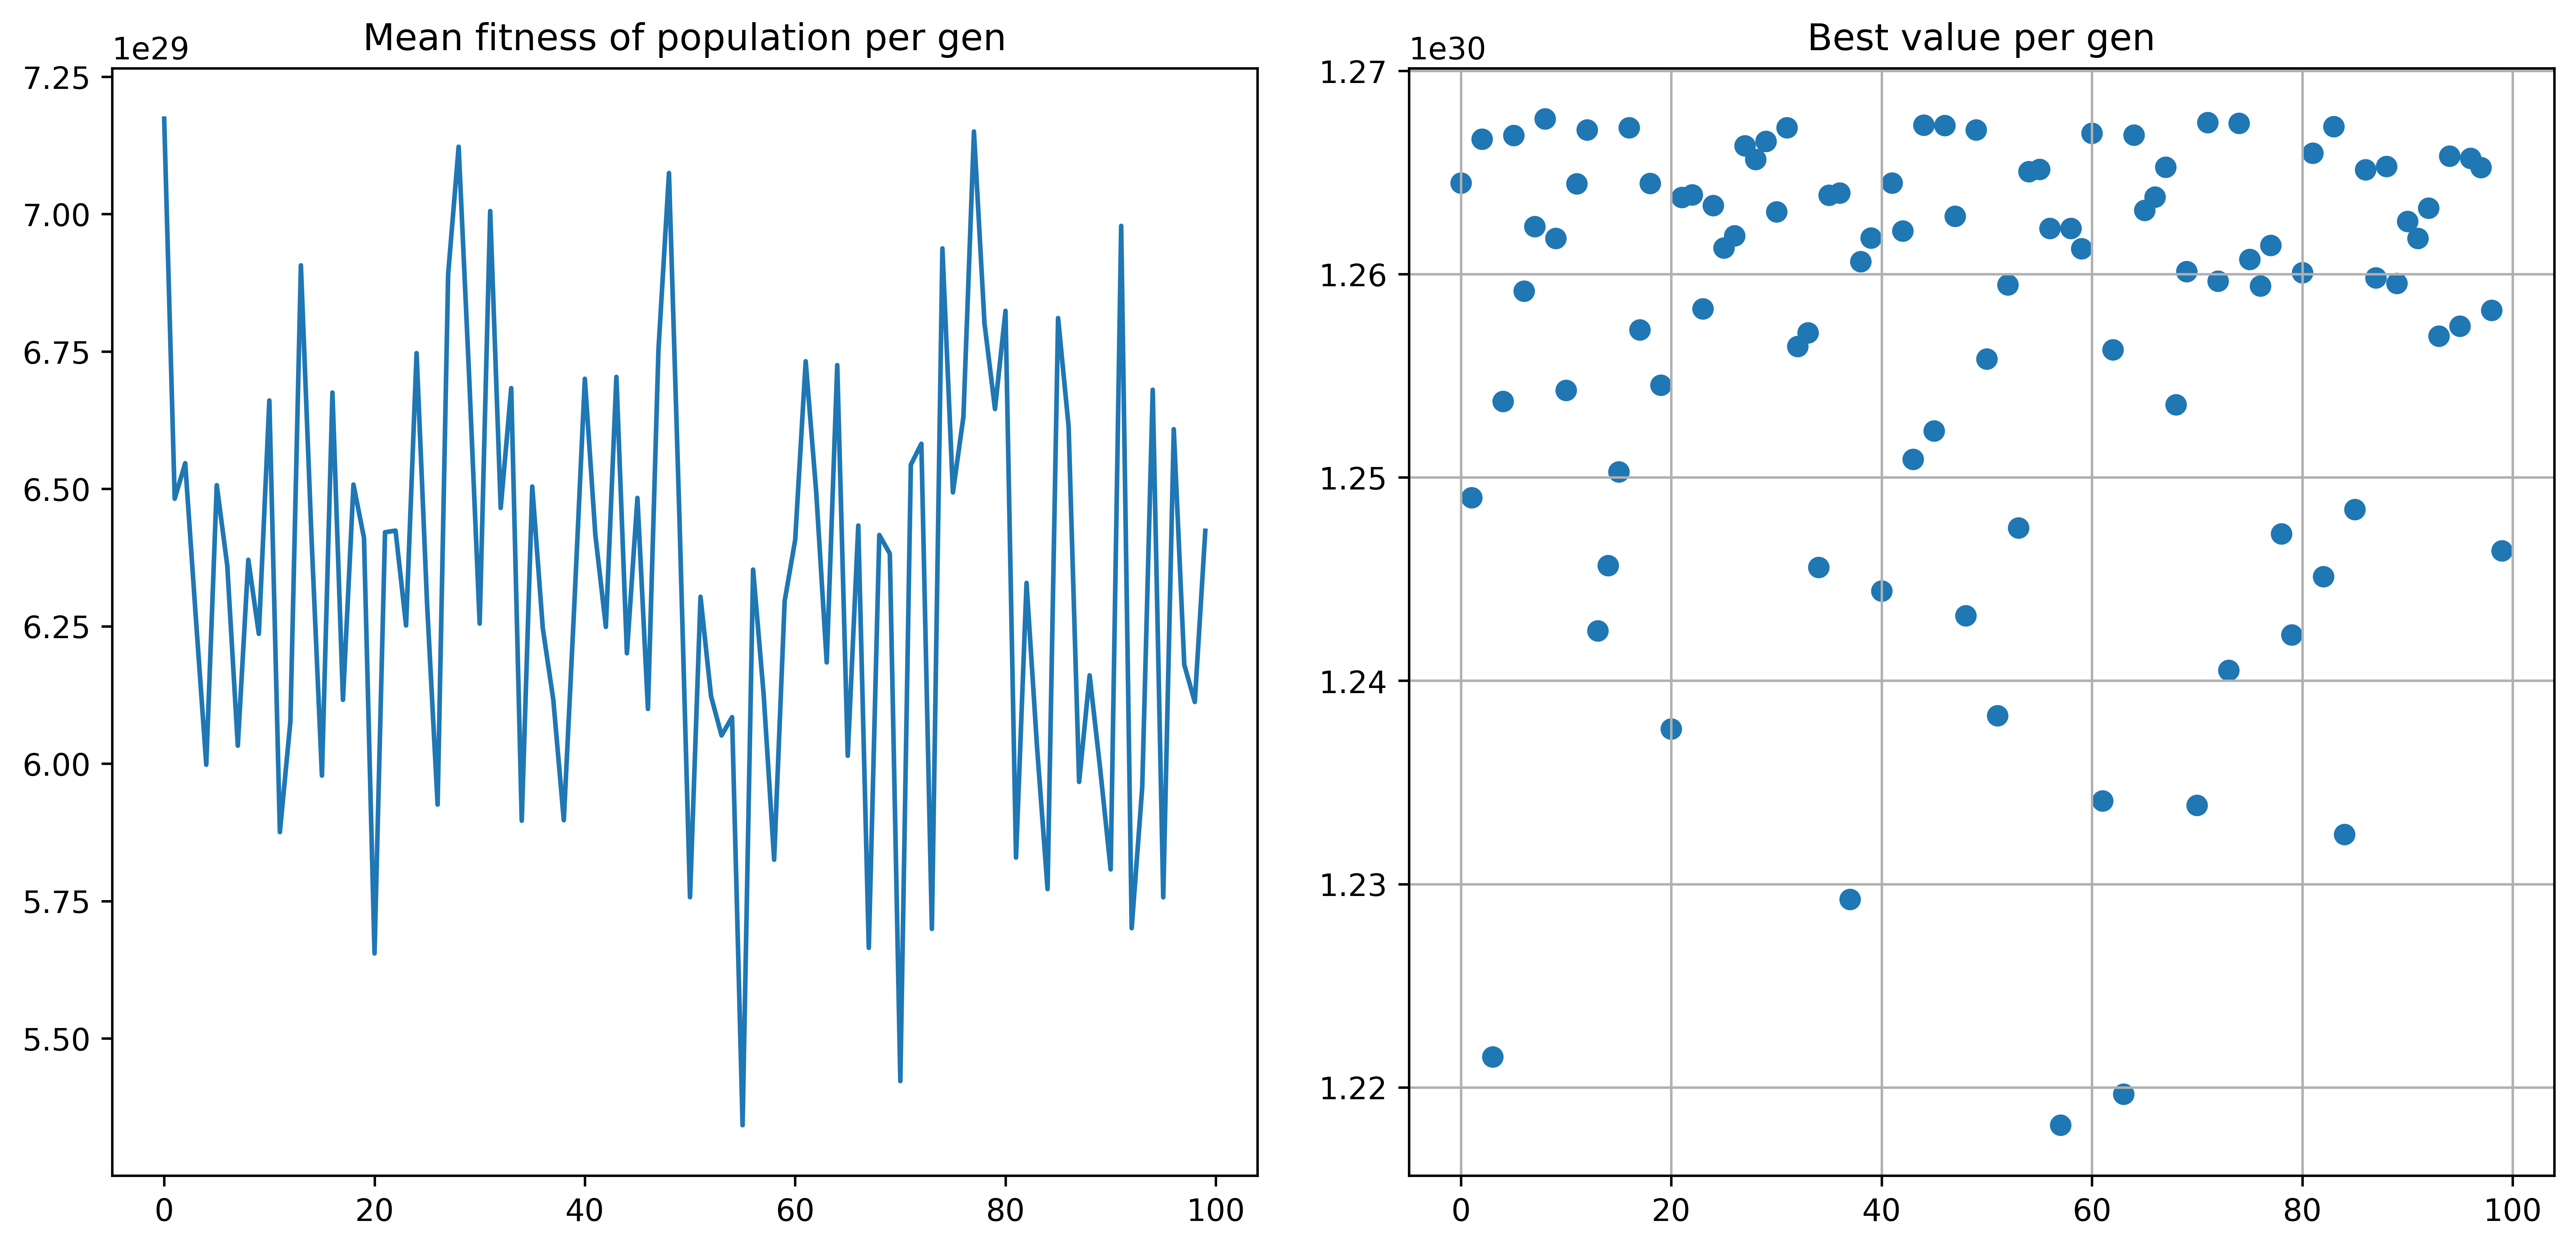

In [ ]:
n = 100
chrom_len = 100
pc = .7
pm = 1e-3
start_time = time.time()
MEAN_FITNESSES = []
BESTS = []
GENS = 100

for gen in range(GENS):
  population = np.random.randint(0, 2, (n, chrom_len))
  fitness_scores = np.array([fitness(member) for member in population])
  # print(fitness_scores)
  # find parents
  total_fitness = np.sum(fitness_scores)
  fitness_norm = np.array(fitness_scores / total_fitness,dtype=np.float64)
  best = np.max(fitness_scores)
  BESTS.append(best) # will be scatterplotted later on
  MEAN_FITNESSES.append(np.mean(fitness_scores))
  k = 100
  dad = select_parent(population, fitness_norm, k=k)
  mom = select_parent(population, fitness_norm, k=k)
  for index in range(0,len(population), 2):
    # replace the whole population
    daddy = dad[np.random.randint(len(dad))]
    mommy = mom[np.random.randint(len(mom))]
    # with children from the parent
    c1, c2 = crossover(daddy, mommy, pc, pm)
    population[index] = c1
    population[index+1] = c2


total_time = time.time() - start_time
x = np.arange(GENS)
BESTS = np.array(BESTS)

MEAN_FITNESSES = np.array(MEAN_FITNESSES)

fig = plt.figure(figsize=(12,6),dpi=600)

plt.subplot(1,2,1)
plt.plot(x, MEAN_FITNESSES, label='Mean fitness of population')
plt.title('Mean fitness of population per gen')
# plt.plot([], [], ' ', label=f'Total time {total_time:.2f} sec\nMean fitness: {np.mean(MEAN_FITNESSES)}')
plt.subplot(1,2,2)
plt.scatter(x, BESTS, label='Best members')
# plt.fill_between(x, MEAN_GENS_TAKEN-STD_GENS_TAKEN, MEAN_GENS_TAKEN+STD_GENS_TAKEN, alpha=.4)
plt.tight_layout(pad=2.)
plt.grid()
plt.title(f'Best value per gen')
# fig.title(f'Pc: {pc}, Pm: {pm}')
plt.show()

#### Genetic algorithm implementation without crossover

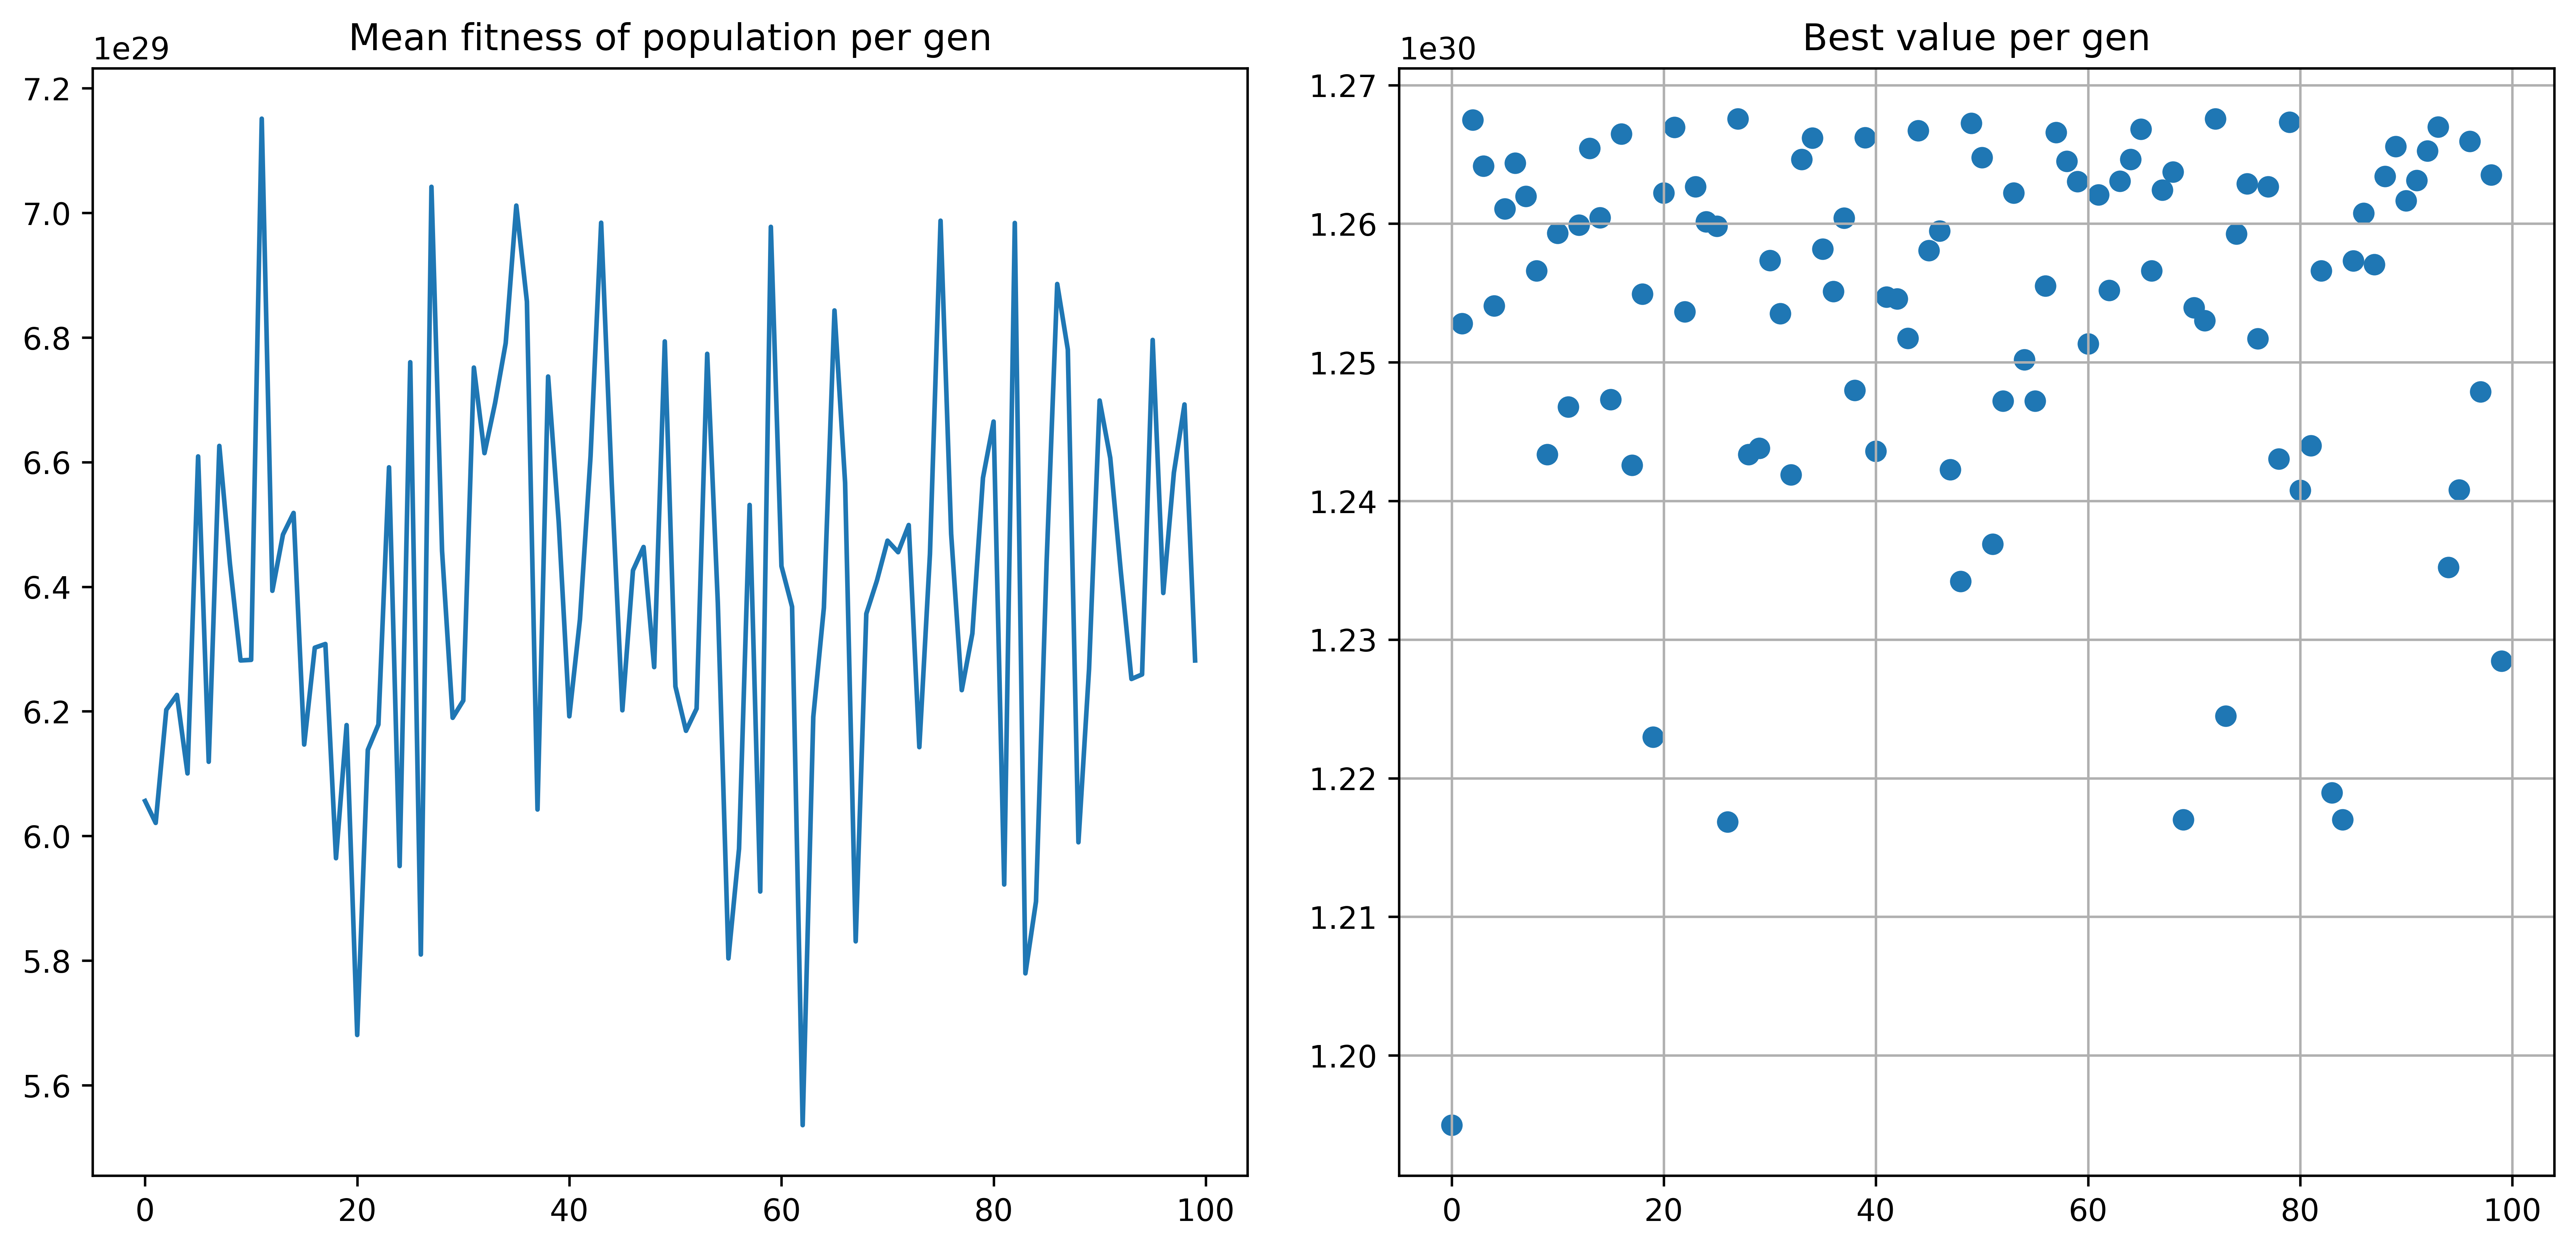

In [ ]:
n = 100
chrom_len = 100
pc = 0.
pm = 1e-3
start_time = time.time()
MEAN_FITNESSES = []
BESTS = []
GENS = 100

for gen in range(GENS):
  population = np.random.randint(0, 2, (n, chrom_len))
  fitness_scores = np.array([fitness(member) for member in population])
  # print(fitness_scores)
  # find parents
  total_fitness = np.sum(fitness_scores)
  fitness_norm = np.array(fitness_scores / total_fitness,dtype=np.float64)
  best = np.max(fitness_scores)
  BESTS.append(best) # will be scatterplotted later on
  MEAN_FITNESSES.append(np.mean(fitness_scores))
  k=100
  dad = select_parent(population, fitness_norm, k=100)
  # for index in range(0,len(population)):
  #   # replace the whole population
  #   daddy = dad[np.random.randint(len(dad))]
  #   # with children from the parent
  #   # c1, c2 = crossover(daddy, mommy, pc, pm)
  #   mutate(daddy, pm)
  population = [mutate(member,pm) for member in population]


total_time = time.time() - start_time
x = np.arange(GENS)
BESTS = np.array(BESTS)

MEAN_FITNESSES = np.array(MEAN_FITNESSES)

fig = plt.figure(figsize=(12,6),dpi=600)

plt.subplot(1,2,1)
plt.plot(x, MEAN_FITNESSES, label='Mean fitness of population')
plt.title('Mean fitness of population per gen')
# plt.plot([], [], ' ', label=f'Total time {total_time:.2f} sec\nMean fitness: {np.mean(MEAN_FITNESSES)}')
plt.subplot(1,2,2)
plt.scatter(x, BESTS, label=f'Best members, k={k}')
# plt.fill_between(x, MEAN_GENS_TAKEN-STD_GENS_TAKEN, MEAN_GENS_TAKEN+STD_GENS_TAKEN, alpha=.4)
plt.tight_layout(pad=2.)
plt.grid()
plt.title(f'Best value per gen, k={k}')
# fig.title(f'Pc: {pc}, Pm: {pm}')
plt.show()

#### Genetic algorithm with many crossover and mutation probabilities

In [ ]:
n = 100
chrom_len = 100
PCs = np.linspace(0.2, 1., 4)
pm = 1e-3
PMs = [1e-3, 1e-2, 1e-1, 1]

fig = plt.figure(figsize=(15,15),dpi=600)
itr = 1
GENS = 100
MEAN_FITNESSES = np.empty((len(PCs), len(PMs), GENS), dtype=np.float32)
BESTS = np.empty((len(PCs), len(PMs), GENS), dtype=np.float32)

# for plotting
LINESTYLES = [':', '--', '-.', 'solid']
MARKERS = ['o', 'P', 'd', 'X']
COLORS = ['blue', 'orange', 'green', 'red']
for pc_index, pc in enumerate(PCs):
  start_time = time.time()
  for pm_index, pm in enumerate(PMs):
    for gen in range(GENS):
      population = np.random.randint(0, 2, (n, chrom_len))
      fitness_scores = np.array([fitness(member) for member in population])
      # print(fitness_scores)
      # find parents
      total_fitness = np.sum(fitness_scores)
      fitness_norm = np.array(fitness_scores / total_fitness,dtype=np.float64)
      best = np.max(fitness_scores)
      BESTS[pc_index, pm_index, gen] = (best) # will be scatterplotted later on
      MEAN_FITNESSES[pc_index, pm_index, gen] = (np.mean(fitness_scores))
      K = 100
      dad = select_parent(population, fitness_norm, k=K)
      mom = select_parent(population, fitness_norm, k=K)
      for index in range(0,len(population), 2):
        # replace the whole population
        daddy = dad[np.random.randint(len(dad))]
        mommy = mom[np.random.randint(len(mom))]
        # with children from the parent
        c1, c2 = crossover(daddy, mommy, pc, pm)
        population[index] = c1
        population[index+1] = c2


    total_time = time.time() - start_time

    x = np.arange(GENS)

    # BESTS = np.array(BESTS)
    # MEAN_FITNESSES = np.array(MEAN_FITNESSES)
    ax = plt.subplot(5,2,itr)
    # {np.mean(MEAN_FITNESSES[pc_index, pm_index, :]):.2e}
    ax.set_title(f'Pc: {pc:.1f}\nMean fitness\ntotal time: {total_time:.1f}')
    ax.axhline(y=np.mean(MEAN_FITNESSES[pc_index, pm_index, :]),color = COLORS[pm_index], linestyle='solid')
    ax.plot(x, MEAN_FITNESSES[pc_index, pm_index, :], label=f'Mean fitness, pm: {pm:.2e}',
            linestyle=LINESTYLES[pm_index], alpha=.4)
    ax.legend()
    # plt.plot([], [], ' ', label=f'Total time {total_time:.2f} sec\nMean fitness: {np.mean(MEAN_FITNESSES)}')
    ax = plt.subplot(5,2, itr+1)
    ax.scatter(x, BESTS[pc_index, pm_index, :], label=f'Best members, pm:{pm:.1e}',
               marker=MARKERS[pm_index], alpha=.4, s=10)
    # HARM_MEAN_OF_BESTS = stats.harmonic_mean(BESTS[pc_index, pm_index, :])
    # ax.axhline(y = HARM_MEAN_OF_BESTS, color = COLORS[pm_index], linestyle='solid')

    ax.axhline(y = np.mean(BESTS[pc_index, pm_index, :]), color = COLORS[pm_index], linestyle='solid')
    ax.legend()
    ax.set_title(f'Best value')
    # plt.fill_between(x, MEAN_GENS_TAKEN-STD_GENS_TAKEN, MEAN_GENS_TAKEN+STD_GENS_TAKEN, alpha=.4)
    ax.grid()
  itr += 2
plt.tight_layout(h_pad=3)
plt.show();